# Pipeline

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Common way

We write python code like,

In [1]:
x = 1

def foo(x):
    a = x + 1
    return a

foo(x)

2

This is simple, x -> a(x) -> y, If I want to add b after a and b depends on a,

In [2]:
x = 1

def foo(x):
    a = x + 1
    b = a + 2
    return b

foo(x)

4

x -> a(x) -> b(x) -> y, If I need both value from a, b, just simply returned a and b.

In [3]:
x = 1

def foo(x):
    a = x + 1
    b = a + 2
    return a, b

foo(x)

(2, 4)

x -> a(x) -> y

y -> b(x) -> y1

Now, if I want to make a branch, a -> b -> c, b -> d -> e,

In [4]:
x = 1

def foo(x):
    a = x + 1
    b = a + 2
    c = b + 3
    
    d = b - 1
    e = d - 2
    return a, b, c, d, e

foo(x)

(2, 4, 7, 3, 1)

These still look simple, what if,

`e` as element, `L` as list of elements,

x\[e\] -> a(x)-> y\[l\] -> batch every 3 elements (l\[e,e,e\], ..) -> loop every element apply z(x) -> flatten.

And do not forget, returned all steps.

In [5]:
x = 10

def foo(x):
    
    def a(x):
        return [i for i in range(x)]
    
    y = a(x)
    
    def batch(x, batch_size):
        r = [x[i: i + batch_size] for i in range(0, len(x), batch_size)]
        return r
    
    batched = batch(y, 3)
    
    def z(x):
        return (sum(x), sum(x) / len(x))
    
    batched_z = [z(i) for i in batched]
    
    flatten = []
    for i in batched_z:
        flatten.extend(i)
    
    return y, batched, batched_z, flatten

foo(x)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]],
 [(3, 1.0), (12, 4.0), (21, 7.0), (9, 9.0)],
 [3, 1.0, 12, 4.0, 21, 7.0, 9, 9.0])

When the code grow, it is very hard to understand especially when we have multiple branches and elements to list and vice versa.

So **malaya-speech Pipeline comes to help!**

### Initiate pipeline

Now, I want to do the same,

x\[e\] -> a(x)-> y\[l\] -> batch every 3 elements (l\[e,e,e\], ..) -> loop every element apply z(x) -> flatten.

Using malaya-speech Pipeline.

In [6]:
from malaya_speech import Pipeline

p = Pipeline()

def a(x):
    return [i for i in range(x)]

def z(x):
    return (sum(x), sum(x) / len(x))

pipeline = (
    p.map(a).batching(3).foreach_map(z).flatten()
)

Yep, simple as that! Do not worry, we will look into each interfaces later.

### Pipeline visualization

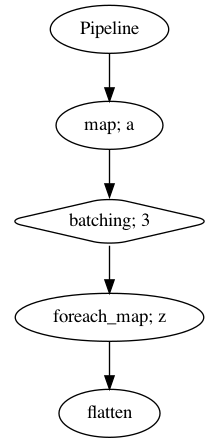

In [7]:
p.visualize()

So now, we can understand what our pipeline trying to do.

In [8]:
result = p.emit(x)
result

{'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'batching': ([0, 1, 2], [3, 4, 5], [6, 7, 8], [9]),
 'z': [(3, 1.0), (12, 4.0), (21, 7.0), (9, 9.0)],
 'flatten': [3, 1.0, 12, 4.0, 21, 7.0, 9, 9.0]}

So the results are pretty same and malaya-speech Pipeline will returned dictionary type.

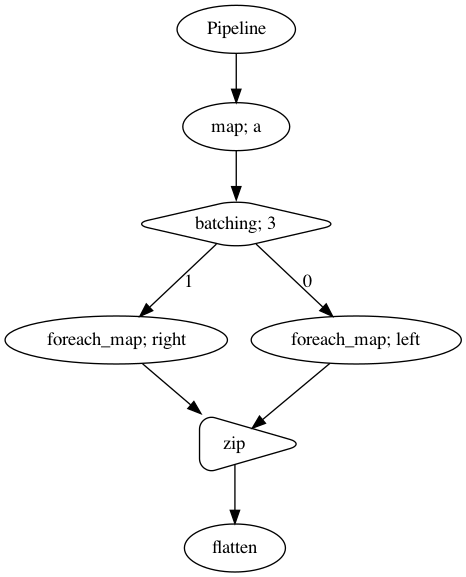

In [9]:
def a(x):
    return [i for i in range(x)]

def left(x):
    return (sum(x), sum(x) / len(x))

def right(x):
    return [i * i for i in x]

p = Pipeline()
batched = p.map(a).batching(3)
pipe_left = batched.foreach_map(left)
pipe_right = batched.foreach_map(right)
combined = pipe_left.zip(pipe_right).flatten()
p.visualize()

In [10]:
result = p.emit(x)
result

{'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'batching': ([0, 1, 2], [3, 4, 5], [6, 7, 8], [9]),
 'left': [(3, 1.0), (12, 4.0), (21, 7.0), (9, 9.0)],
 'right': [[0, 1, 4], [9, 16, 25], [36, 49, 64], [81]],
 'zip': ([(3, 1.0), (12, 4.0), (21, 7.0), (9, 9.0)],
  [[0, 1, 4], [9, 16, 25], [36, 49, 64], [81]]),
 'flatten': [(3, 1.0),
  (12, 4.0),
  (21, 7.0),
  (9, 9.0),
  [0, 1, 4],
  [9, 16, 25],
  [36, 49, 64],
  [81]]}

### Interface

#### map

`map` is simply apply a function for input.

In [11]:
p = Pipeline()
p.map(lambda x: x + 1)
p.emit(2)

{'<lambda>': 3}

In [12]:
p = Pipeline()
p.map(lambda x: x + 1, name = 'plus')
p.emit(2)

{'plus': 3}

In [13]:
def x(a, b):
    return a + b

p = Pipeline()
p.map(x, b = 3, name = 'plus')
p.emit(2)

{'x_plus': 5}

#### batching

`batching` is simply batch elements to size of N.

In [14]:
p = Pipeline()
p.batching(2)
p.emit([1,2,3,4,5])

{'batching': ([1, 2], [3, 4], [5])}

In [15]:
p = Pipeline()
p.batching(2).batching(2)
p.emit([1,2,3,4,5])

{'batching': (([1, 2], [3, 4]), ([5],))}

As you can see, `batching` only returned last `batching` because the key in dictionary is duplicate. So to prevent any duplicate,

In [16]:
p = Pipeline()
p.batching(2).batching(2, name = 'second')
p.emit([1,2,3,4,5])

{'batching': ([1, 2], [3, 4], [5]),
 'batching_second': (([1, 2], [3, 4]), ([5],))}

#### foreach_map

`foreach_map` is simply apply a function for each elements in a list.

In [17]:
p = Pipeline()

def x(a):
    return a * a

p.map(lambda x: [i for i in range(x)], name = 'generate').foreach_map(x)
p.emit(5)

{'generate': [0, 1, 2, 3, 4], 'x': [0, 1, 4, 9, 16]}

In [18]:
p = Pipeline()

def x(a):
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).foreach_map(x)
p.emit(9)

{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

`foreach_map` also provide different methods to process the elements,

```python
class foreach_map(Pipeline):
    """ 
    Apply a function to every element in a tuple in the stream.

    Parameters
    ----------
    func: callable
    method: str, optional (default='sync')
        method to process each elements.

        * ``'sync'`` - loop one-by-one to process.
        * ``'async'`` - async process all elements at the same time.
        * ``'thread'`` - multithreading level to process all elements at the same time. 
                         Default is 1 worker. Override `worker_size=n` to increase.
        * ``'process'`` - multiprocessing level to process all elements at the same time. 
                          Default is 1 worker. Override `worker_size=n` to increase.

    *args :
        The arguments to pass to the function.
    **kwargs:
        Keyword arguments to pass to func.
```

Default is `sync`. If,

1. `async`, you need to install tornado,

```bash
pip3 install tornado
```

2. `thread`, you need to install dask,

```bash
pip3 install dask
```

**We only provided single-machine dask processing**.

3. `process`, you need to install dask,

```bash
pip3 install dask
```

**We only provided single-machine dask processing**.

In [19]:
import time

p = Pipeline()

def x(a):
    time.sleep(1)
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).foreach_map(x)

<foreach_map: x>

In [20]:
%%time

p.emit(9)

CPU times: user 940 µs, sys: 1.03 ms, total: 1.97 ms
Wall time: 5.01 s


{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

In [21]:
p = Pipeline()

def x(a):
    time.sleep(1)
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).foreach_map(x, method = 'async')

<foreach_map: x>

In [22]:
%%time

p.emit(9)

CPU times: user 1.46 ms, sys: 891 µs, total: 2.36 ms
Wall time: 5.01 s


{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

**asynchronous != concurrency**.

In [23]:
p = Pipeline()

def x(a):
    time.sleep(1)
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).foreach_map(x, method = 'thread')

<foreach_map: x>

In [24]:
%%time

p.emit(9)

CPU times: user 9.64 ms, sys: 4.41 ms, total: 14.1 ms
Wall time: 5.01 s


{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

Try to increase the worker size, `worker_size=n`.

In [25]:
p = Pipeline()

def x(a):
    time.sleep(1)
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2)\
.foreach_map(x, method = 'thread', worker_size = 5)

<foreach_map: x>

In [26]:
%%time

p.emit(9)

CPU times: user 5.58 ms, sys: 2.33 ms, total: 7.91 ms
Wall time: 1 s


{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

**We do not suggest use threading level to process a very extensive function, so, use processing level instead**.

In [27]:
p = Pipeline()

def x(a):
    time.sleep(1)
    return sum(a)

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2)\
.foreach_map(x, method = 'process', worker_size = 5)

<foreach_map: x>

In [28]:
%%time

p.emit(9)

CPU times: user 27.5 ms, sys: 40.8 ms, total: 68.3 ms
Wall time: 1.32 s


{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8]),
 'x': [1, 5, 9, 13, 8]}

**Perfecto!**

#### partition

`partition` is simply to group multiple `emit` into N size of tuple. Each successful partition, N count will reset.

In [29]:
p = Pipeline()
p.partition(3).map(lambda x: sum(x), name = 'sum')
p.emit(1)

{}

First emit nothing happened because `partition` only proceed if we `emit` after N size.

In [30]:
p.emit(2)

{}

In [31]:
p.emit(3)

{'partition': (1, 2, 3), 'sum': 6}

In [32]:
p.emit(4) # not yet, N count reset, returned last state

{'partition': (1, 2, 3), 'sum': 6}

In [33]:
p.emit(5) # not yet, N count reset, returned last state

{'partition': (1, 2, 3), 'sum': 6}

In [34]:
p.emit(6)

{'partition': (4, 5, 6), 'sum': 15}

#### sliding_window

`partition` is simply to group multiple `emit` into N size of tuple.

In [35]:
p = Pipeline()
p.sliding_window(3).map(lambda x: sum(x), name = 'sum')
p.emit(1)

{'sliding_window': (1,), 'sum': 1}

In [36]:
p.emit(2)

{'sliding_window': (1, 2), 'sum': 3}

In [37]:
p.emit(3)

{'sliding_window': (1, 2, 3), 'sum': 6}

In [38]:
p.emit(4)

{'sliding_window': (2, 3, 4), 'sum': 9}

If you want exact size of N,

In [39]:
p = Pipeline()
p.sliding_window(3, return_partial = False).map(lambda x: sum(x), name = 'sum')
p.emit(1)

{}

In [40]:
p.emit(2)

{}

In [41]:
p.emit(3)

{'sliding_window': (1, 2, 3), 'sum': 6}

In [42]:
p.emit(4)

{'sliding_window': (2, 3, 4), 'sum': 9}

#### flatten

`flatten` simply to flatten nested list.

In [43]:
p = Pipeline()

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).flatten()
p.emit(10)

{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'batching': ([0, 1], [2, 3], [4, 5], [6, 7], [8, 9]),
 'flatten': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [44]:
p = Pipeline()

p.map(lambda x: [i for i in range(x)], name = 'generate').batching(2).batching(3).flatten().flatten(name = 'nested')
p.emit(10)

{'generate': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'batching': (([0, 1], [2, 3], [4, 5]), ([6, 7], [8, 9])),
 'flatten': [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
 'flatten_nested': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

#### zip

`zip` is to combine 2 branches into 1 branch.

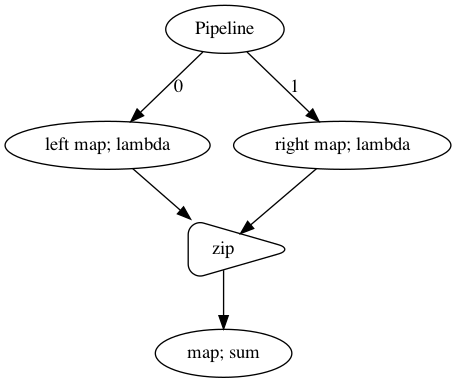

In [45]:
p = Pipeline()

left = p.map(lambda x: x + 1, name = 'left')
right = p.map(lambda x: x + 10, name = 'right')
left.zip(right).map(sum)
p.visualize()

In [46]:
p.emit(2)

{'left': 3, 'right': 12, 'zip': (3, 12), 'sum': 15}

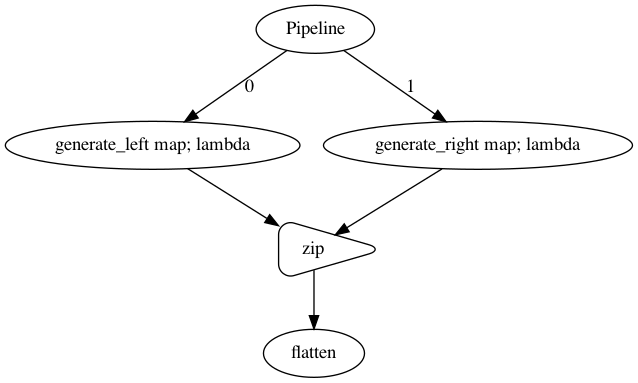

In [47]:
p = Pipeline()

left = p.map(lambda x: [i + 1 for i in range(x)], name = 'generate_left')
right = p.map(lambda x: [i + 10 for i in range(x)], name = 'generate_right')
left.zip(right).flatten()
p.visualize()

In [48]:
p.emit(5)

{'generate_left': [1, 2, 3, 4, 5],
 'generate_right': [10, 11, 12, 13, 14],
 'zip': ([1, 2, 3, 4, 5], [10, 11, 12, 13, 14]),
 'flatten': [1, 2, 3, 4, 5, 10, 11, 12, 13, 14]}

#### foreach_zip

`foreach_zip` same like `zip`, combine 2 branches into 1 branch, but will zip left and right hand sides for each elements.

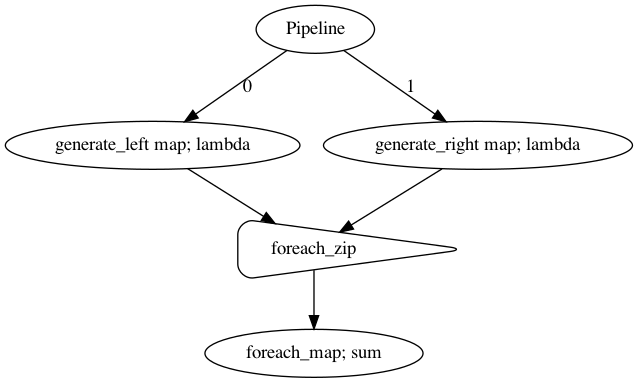

In [49]:
p = Pipeline()

left = p.map(lambda x: [i + 1 for i in range(x)], name = 'generate_left')
right = p.map(lambda x: [i + 10 for i in range(x)], name = 'generate_right')
left.foreach_zip(right).foreach_map(sum)
p.visualize()

In [50]:
p.emit(5)

{'generate_left': [1, 2, 3, 4, 5],
 'generate_right': [10, 11, 12, 13, 14],
 'foreach_zip': ((1, 10), (2, 11), (3, 12), (4, 13), (5, 14)),
 'sum': [11, 13, 15, 17, 19]}